In [33]:
import tika
from tika import parser
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
import warnings
from imp import reload
warnings.filterwarnings("ignore")

In [2]:
topics = 5

In [3]:
tika.initVM()
parsed = parser.from_file('article3.pdf')
metadados = parsed["metadata"]
texto = parsed["content"]

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
def split_pdf(string): 
    li = list(string.split(" ")) 
    return li

In [6]:
def first_clear(data):
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    #remove links and mark
    data = [re.sub('(https:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(http:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(www.:\S+)|(@)|(¿)', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # remove spaces in begining and end
    data = [re.sub(' +', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    return data

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [8]:
def bi_tri_gram(data):
    bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data], threshold=100) 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    return bigram_mod, trigram_mod

In [9]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [10]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [11]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [12]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
def filter_pos_tagging(data, pos):
    lista = []
    for token in data:
        for p in pos:
            if (token.pos_ == p):
                lista.append(token.text)
#                 print(token.text)

    
    return [[el] for el in lista]

In [15]:
nlp = spacy.load('en', disable=['parser', 'ner'])
mallet_path = 'mallet-2.0.8/bin/mallet' 

data = split_pdf(texto)
# print(data)

data = first_clear(data)
# print(data)

data = list(sent_to_words(data))

# Remove Stop Words
data_words_nostops = remove_stopwords(data)

aggregate = {}
list_pos = [['NOUN'], ['ADJ'], ['NOUN', 'ADJ']]

for i in range(0, len(list_pos)):
    l = []
    data_filtered = filter_pos_tagging(nlp(str(data_words_nostops)), list_pos[i] )

    bigram_mod, trigram_mod = bi_tri_gram(data_filtered)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_filtered)
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    id2word = corpora.Dictionary(data_lemmatized)
    texts = data_lemmatized
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=topics,random_state=100,\
                                            update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
    
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=topics, id2word=id2word)
    
    l.append(list_pos[i])
    l.append(data_lemmatized)
    l.append(id2word)
    l.append(corpus)
    l.append(lda_model)
    l.append(ldamallet)
    aggregate[i] = l

# Tópicos apenas levando em conta os Substantivos

In [16]:
pprint(aggregate[0][4].print_topics())
doc_lda = aggregate[0][4][aggregate[0][3]]

[(0,
  '0.093*"shamir" + 0.093*"style" + 0.047*"art" + 0.045*"journal" + '
  '0.044*"phylogeny" + 0.038*"figure" + 0.024*"technology" + 0.023*"link" + '
  '0.023*"aesthetic" + 0.020*"science"'),
 (1,
  '0.095*"computer" + 0.059*"similarity" + 0.042*"colony" + 0.036*"pollock" + '
  '0.021*"history" + 0.018*"berlin" + 0.018*"home" + 0.018*"distance" + '
  '0.018*"study" + 0.017*"streetview"'),
 (2,
  '0.081*"analysis" + 0.070*"city" + 0.054*"classification" + '
  '0.041*"perception" + 0.037*"method" + 0.031*"heritage" + '
  '0.023*"transaction" + 0.022*"datum" + 0.019*"vision" + 0.018*"environment"'),
 (3,
  '0.158*"image" + 0.108*"architecture" + 0.028*"location" + 0.028*"research" '
  '+ 0.027*"system" + 0.026*"planning" + 0.021*"compute" + 0.017*"recognition" '
  '+ 0.016*"source" + 0.015*"show"'),
 (4,
  '0.072*"building" + 0.052*"interest" + 0.052*"region" + 0.038*"information" '
  '+ 0.037*"machine" + 0.029*"conference" + 0.019*"macura" + 0.019*"orlov" + '
  '0.018*"press" + 0.017*

In [17]:
print('\nPerplexity: ', aggregate[0][4].log_perplexity(aggregate[0][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=aggregate[0][4], texts=aggregate[0][1], dictionary=aggregate[0][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.464593057159519

Coherence Score:  0.8384848773708363


In [18]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(aggregate[0][4], aggregate[0][3], aggregate[0][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.267646  0.083568       1        1  24.547764
4     -0.018623 -0.033083       2        1  20.905014
0     -0.186059  0.201092       3        1  19.394392
2     -0.058602 -0.245847       4        1  18.820255
1     -0.004362 -0.005731       5        1  16.332577, topic_info=    Category       Freq           Term      Total  loglift  logprob
8    Default  68.000000          image  68.000000  30.0000  30.0000
7    Default  46.000000   architecture  46.000000  29.0000  29.0000
13   Default  32.000000         shamir  32.000000  28.0000  28.0000
31   Default  32.000000          style  32.000000  27.0000  27.0000
5    Default  27.000000       computer  27.000000  26.0000  26.0000
..       ...        ...            ...        ...      ...      ...
200   Topic5   2.972638         number   3.609941   1.6178  -4.5590
144   Topic5   2.961181      frankfurt   3.598454   1.6171  -4.5629
145   Topic5   2.961181        hamburg   3.598454   1.6171  -4.5629
302   Topic5   2.599951       colonial   3.239247   1.5922  -4.6930
232   Topic5   2.520206  expressionism   3.159540   1.5859  -4.7241

[186 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
206       2  0.932944     accuracy
62        3  0.946773    aesthetic
119       4  0.744938          age
222       5  0.920246    agreement
6         4  0.963466     analysis
...     ...       ...          ...
212       2  0.920745      wndchrm
460       5  0.764291         xiao
448       4  0.766851       yuriko
120       4  0.744938  zeppelzauer
102       4  0.724844        zhang

[156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 3, 2])

In [19]:
pprint(aggregate[0][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=aggregate[0][5], texts=aggregate[0][1], dictionary=aggregate[0][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.141*"building" + 0.101*"shamir" + 0.089*"similarity" + 0.061*"phylogeny" '
  '+ 0.046*"content" + 0.037*"datum" + 0.024*"dataset" + 0.021*"result" + '
  '0.018*"planning" + 0.015*"mexico"'),
 (1,
  '0.083*"interest" + 0.061*"figure" + 0.053*"streetview" + 0.039*"distance" + '
  '0.039*"art" + 0.033*"feature" + 0.033*"tile" + 0.031*"link" + '
  '0.025*"system" + 0.025*"experiment"'),
 (2,
  '0.153*"architecture" + 0.110*"analysis" + 0.063*"location" + 0.040*"class" '
  '+ 0.037*"method" + 0.026*"show" + 0.020*"research" + 0.017*"phylip" + '
  '0.017*"label" + 0.017*"history"'),
 (3,
  '0.328*"image" + 0.084*"region" + 0.052*"classification" + 0.038*"colony" + '
  '0.029*"information" + 0.029*"pattern" + 0.026*"system" + 0.020*"country" + '
  '0.020*"vision" + 0.020*"recognition"'),
 (4,
  '0.134*"city" + 0.131*"style" + 0.077*"computer" + 0.039*"set" + '
  '0.030*"accuracy" + 0.027*"machine" + 0.021*"sample" + 0.018*"difference" + '
  '0.018*"part" + 0.018*"study"')]

Coherenc

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=aggregate[0][2], corpus=aggregate[0][3], texts=aggregate[0][1], start=2, limit=40, step=6)


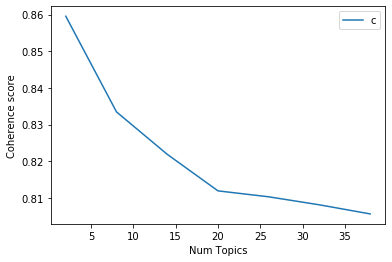

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Tópicos apenas levando em conta os Adjetivos


In [22]:
pprint(aggregate[1][4].print_topics())
doc_lda = aggregate[1][4][aggregate[1][3]]

[(0,
  '0.258*"different" + 0.106*"visual" + 0.078*"quantitative" + '
  '0.057*"european" + 0.040*"relate" + 0.037*"large" + 0.032*"geographic" + '
  '0.020*"geological" + 0.020*"climatic" + 0.019*"astronomical"'),
 (1,
  '0.122*"urban" + 0.058*"complex" + 0.052*"better" + 0.049*"able" + '
  '0.042*"religious" + 0.041*"open" + 0.036*"computational" + '
  '0.033*"influential" + 0.031*"abstract" + 0.027*"short"'),
 (2,
  '0.117*"cultural" + 0.089*"british" + 0.068*"former" + 0.054*"standard" + '
  '0.044*"asian" + 0.044*"spanish" + 0.040*"new" + 0.035*"german" + '
  '0.032*"present" + 0.028*"low"'),
 (3,
  '0.265*"architectural" + 0.075*"close" + 0.048*"high" + 0.035*"numerical" + '
  '0.032*"sensitive" + 0.028*"informative" + 0.027*"correct" + 0.026*"first" + '
  '0.025*"residential" + 0.025*"irfanview"'),
 (4,
  '0.099*"automatic" + 0.057*"international" + 0.052*"social" + '
  '0.045*"similar" + 0.041*"islamic" + 0.028*"original" + 0.025*"available" + '
  '0.023*"artistic" + 0.023*"dee

In [23]:
print('\nPerplexity: ', aggregate[1][4].log_perplexity(aggregate[1][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=aggregate[1][4], texts=aggregate[1][1], dictionary=aggregate[1][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.52493691286673

Coherence Score:  0.8411807519063667


In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(aggregate[1][4], aggregate[1][3], aggregate[1][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.283856 -0.031220       1        1  30.595726
2     -0.117663 -0.237208       2        1  20.629364
4     -0.089107  0.168399       3        1  19.408222
0     -0.043393  0.069359       4        1  15.401512
1     -0.033693  0.030671       5        1  13.965179, topic_info=    Category       Freq           Term      Total  loglift  logprob
6    Default  40.000000  architectural  40.000000  30.0000  30.0000
13   Default  20.000000      different  20.000000  29.0000  29.0000
26   Default  12.000000       cultural  12.000000  28.0000  28.0000
49   Default   9.000000          urban   9.000000  27.0000  27.0000
7    Default   8.000000         visual   8.000000  26.0000  26.0000
..       ...        ...            ...        ...      ...      ...
51    Topic5   0.140063           main   1.070172  -0.0649  -6.2036
154   Topic5   0.140075   astronomical   2.051385  -0.7155  -6.2035
125   Topic5   0.140074        spatial   1.818647  -0.5951  -6.2036
122   Topic5   0.140074      dependent   1.818647  -0.5951  -6.2036
123   Topic5   0.140074     impossible   1.818647  -0.5951  -6.2036

[214 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
10        5  0.744884        able
3         5  0.728174    abstract
121       5  0.618113  accessible
129       3  0.549859    american
70        1  0.734228    annotate
...     ...       ...         ...
49        5  0.884653       urban
105       2  0.699995      useful
82        1  0.734228     various
7         4  0.921666      visual
85        1  0.734228         von

[142 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 5, 1, 2])

In [25]:
pprint(aggregate[1][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=aggregate[1][5], texts=aggregate[1][1], dictionary=aggregate[1][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.205*"automatic" + 0.167*"visual" + 0.141*"close" + 0.051*"religious" + '
  '0.051*"social" + 0.051*"architectural" + 0.026*"historical" + '
  '0.026*"environmental" + 0.026*"technological" + 0.013*"global"'),
 (1,
  '0.096*"standard" + 0.084*"numerical" + 0.072*"similar" + 0.072*"correct" + '
  '0.060*"due" + 0.048*"german" + 0.048*"influential" + 0.048*"european" + '
  '0.048*"computational" + 0.036*"difficult"'),
 (2,
  '0.099*"quantitative" + 0.099*"complex" + 0.074*"british" + '
  '0.074*"informative" + 0.062*"international" + 0.062*"asian" + '
  '0.049*"original" + 0.049*"relate" + 0.037*"equal" + 0.037*"geographic"'),
 (3,
  '0.435*"architectural" + 0.076*"high" + 0.054*"islamic" + 0.054*"typical" + '
  '0.043*"low" + 0.033*"geographical" + 0.033*"mere" + 0.033*"present" + '
  '0.033*"british" + 0.033*"irfanview"'),
 (4,
  '0.160*"cultural" + 0.111*"urban" + 0.074*"sensitive" + 0.062*"spanish" + '
  '0.037*"flat" + 0.037*"residential" + 0.037*"clear" + 0.037*"open" + '


In [34]:
model_list, coherence_values = compute_coherence_values(dictionary=aggregate[1][2], corpus=aggregate[1][3], texts=aggregate[1][1], start=2, limit=40, step=6)


KeyError: 415

In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Tópicos levando em conta os Adjetivos e Substantivos


In [27]:
pprint(aggregate[2][4].print_topics())
doc_lda = aggregate[2][4][aggregate[2][3]]

[(0,
  '0.070*"shamir" + 0.057*"architectural" + 0.040*"classification" + '
  '0.037*"interest" + 0.036*"region" + 0.034*"similarity" + 0.031*"phylogeny" '
  '+ 0.016*"proceeding" + 0.016*"macura" + 0.013*"result"'),
 (1,
  '0.077*"style" + 0.060*"building" + 0.034*"perception" + 0.031*"automatic" + '
  '0.029*"british" + 0.027*"colony" + 0.023*"system" + 0.021*"transaction" + '
  '0.017*"recognition" + 0.013*"berlin"'),
 (2,
  '0.070*"analysis" + 0.065*"computer" + 0.056*"city" + 0.036*"machine" + '
  '0.031*"urban" + 0.029*"research" + 0.026*"planning" + 0.020*"datum" + '
  '0.019*"orlov" + 0.017*"comparison"'),
 (3,
  '0.142*"image" + 0.101*"architecture" + 0.044*"journal" + 0.030*"pollock" + '
  '0.027*"heritage" + 0.024*"location" + 0.023*"aesthetic" + 0.016*"former" + '
  '0.014*"home" + 0.012*"phylip"'),
 (4,
  '0.033*"art" + 0.027*"cultural" + 0.027*"international" + '
  '0.027*"information" + 0.026*"method" + 0.024*"different" + 0.023*"figure" + '
  '0.022*"conference" + 0.018

In [28]:
print('\nPerplexity: ', aggregate[2][4].log_perplexity(aggregate[2][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=aggregate[2][4], texts=aggregate[2][1], dictionary=aggregate[2][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.939470235548494

Coherence Score:  0.8381212277423135


In [29]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(aggregate[2][4], aggregate[2][3], aggregate[2][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.156212  0.210958       1        1  23.449062
0     -0.269622  0.070559       2        1  22.164078
1      0.024569 -0.041725       3        1  19.605204
3      0.056041 -0.216843       4        1  17.545938
2      0.032801 -0.022948       5        1  17.235714, topic_info=    Category       Freq          Term      Total  loglift  logprob
9    Default  56.000000         image  56.000000  30.0000  30.0000
7    Default  40.000000  architecture  40.000000  29.0000  29.0000
38   Default  34.000000         style  34.000000  28.0000  28.0000
15   Default  35.000000        shamir  35.000000  27.0000  27.0000
6    Default  27.000000      analysis  27.000000  26.0000  26.0000
..       ...        ...           ...        ...      ...      ...
618   Topic5   3.588186        sparse   4.410348   1.5519  -4.6757
597   Topic5   3.588165        winner   4.410349   1.5519  -4.6757
607   Topic5   3.588163    despotovic   4.410349   1.5519  -4.6757
606   Topic5   3.588152      identity   4.410349   1.5519  -4.6757
613   Topic5   3.588150     retrieval   4.410349   1.5519  -4.6757

[188 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
21        3  0.813473     abstract
280       5  0.901254     accuracy
79        4  0.923434    aesthetic
168       5  0.888390          age
190       3  0.849076         aire
...     ...       ...          ...
292       1  0.842734      wndchrm
615       4  0.894233         xiao
602       4  0.894233       yuriko
169       5  0.888390  zeppelzauer
150       2  0.823497        zhang

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 4, 3])

In [30]:
pprint(aggregate[1][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=aggregate[2][5], texts=aggregate[2][1], dictionary=aggregate[2][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.205*"automatic" + 0.167*"visual" + 0.141*"close" + 0.051*"religious" + '
  '0.051*"social" + 0.051*"architectural" + 0.026*"historical" + '
  '0.026*"environmental" + 0.026*"technological" + 0.013*"global"'),
 (1,
  '0.096*"standard" + 0.084*"numerical" + 0.072*"similar" + 0.072*"correct" + '
  '0.060*"due" + 0.048*"german" + 0.048*"influential" + 0.048*"european" + '
  '0.048*"computational" + 0.036*"difficult"'),
 (2,
  '0.099*"quantitative" + 0.099*"complex" + 0.074*"british" + '
  '0.074*"informative" + 0.062*"international" + 0.062*"asian" + '
  '0.049*"original" + 0.049*"relate" + 0.037*"equal" + 0.037*"geographic"'),
 (3,
  '0.435*"architectural" + 0.076*"high" + 0.054*"islamic" + 0.054*"typical" + '
  '0.043*"low" + 0.033*"geographical" + 0.033*"mere" + 0.033*"present" + '
  '0.033*"british" + 0.033*"irfanview"'),
 (4,
  '0.160*"cultural" + 0.111*"urban" + 0.074*"sensitive" + 0.062*"spanish" + '
  '0.037*"flat" + 0.037*"residential" + 0.037*"clear" + 0.037*"open" + '


In [31]:
model_list, coherence_values = compute_coherence_values(dictionary=aggregate[2][2], corpus=aggregate[2][3], texts=aggregate[2][1], start=2, limit=40, step=6)


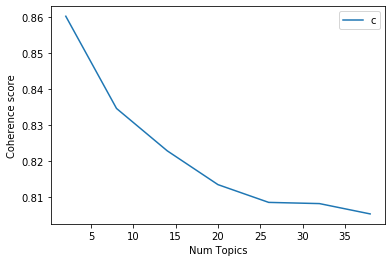

In [32]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()